In [12]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


PyTorch version: 2.8.0+cu126
CUDA available: True
Device: cuda


In [22]:
from google.colab import files
uploaded = files.upload()  # browse your train_test.zip and upload


Saving train_test.zip.zip to train_test.zip.zip


In [23]:
!unzip /content/train_test.zip -d /content/data


Archive:  /content/train_test.zip.zip
   creating: /content/data/train_test/
   creating: /content/data/train_test/Test/
   creating: /content/data/train_test/Test/cat/
  inflating: /content/data/train_test/Test/cat/cats_00003.jpg  
  inflating: /content/data/train_test/Test/cat/cats_00004.jpg  
   creating: /content/data/train_test/Test/dog/
  inflating: /content/data/train_test/Test/dog/dogs_00007.jpg  
  inflating: /content/data/train_test/Test/dog/dogs_00008.jpg  
   creating: /content/data/train_test/Test/panda/
  inflating: /content/data/train_test/Test/panda/panda_00001.jpg  
  inflating: /content/data/train_test/Test/panda/panda_00016.jpg  
   creating: /content/data/train_test/Train/
   creating: /content/data/train_test/Train/cat/
  inflating: /content/data/train_test/Train/cat/cats_00003.jpg  
  inflating: /content/data/train_test/Train/cat/cats_00004.jpg  
   creating: /content/data/train_test/Train/dog/
  inflating: /content/data/train_test/Train/dog/dogs_00008.jpg  
   cr

In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Load dataset
train_data = datasets.ImageFolder(root="/content/data/train_test/Train", transform=train_transform)
test_data  = datasets.ImageFolder(root="/content/data/train_test/Test", transform=test_transform)

# DataLoader
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=2, shuffle=False)

print("Classes:", train_data.classes)  # ['cat', 'dog', 'panda']


Classes: ['cat', 'dog', 'panda']


In [26]:
import torch
import torch.nn as nn
from torchvision import models

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)

# Freeze all convolutional layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier (fc layer) for 3 classes
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 3)  # cat, dog, panda
)

# Move model to GPU if available
model = model.to(device)

print(model)


Using device: cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

# Epochs
num_epochs = 5

best_acc = 0.0

for epoch in range(num_epochs):
    model.train()  # set model to training mode
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        # Move to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass + optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.double() / len(train_data)

    print(f"Epoch {epoch+1}/{num_epochs} -> Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

    # Save best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved!")


Epoch 1/5 -> Loss: 1.3065, Acc: 0.2000
Best model saved!
Epoch 2/5 -> Loss: 1.1503, Acc: 0.4000
Best model saved!
Epoch 3/5 -> Loss: 0.9566, Acc: 0.6000
Best model saved!
Epoch 4/5 -> Loss: 1.3051, Acc: 0.4000
Epoch 5/5 -> Loss: 0.8729, Acc: 0.6000


In [29]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Test accuracy
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

test_acc = running_corrects.double() / len(test_data)
print("Test Accuracy:", test_acc.item())


Test Accuracy: 0.3333333333333333


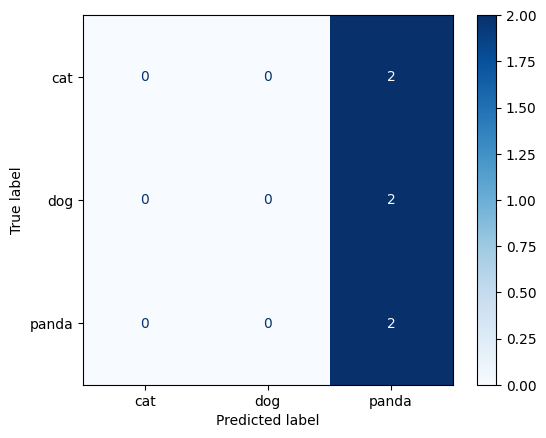

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Collect all predictions & labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


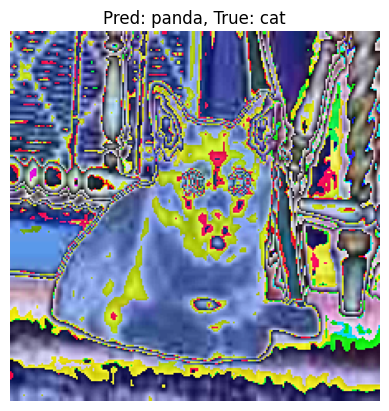

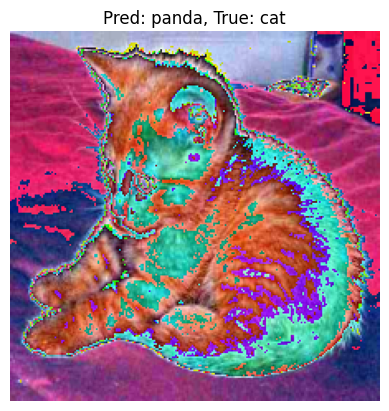

In [56]:
import matplotlib.pyplot as plt
import torchvision

# Get one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Show images and predictions
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

for idx in range(len(images)):
    img = torchvision.transforms.functional.to_pil_image(images[idx])
    plt.imshow(img)
    plt.title(f"Pred: {train_data.classes[preds[idx]]}, True: {train_data.classes[labels[idx]]}")
    plt.axis('off')
    plt.show()
